#### Install and Import library

In [9]:
!pip install openpyxl
!pip install opencv-python
!pip install torchmetrics
!pip install torchvision


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 12.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
from torchvision.transforms import InterpolationMode as Inter
from torchmetrics.classification import MulticlassJaccardIndex
import time
import torch.nn.functional as F

#### Setup labels and Class Colors

In [12]:
# set up dataset addresses
data_path = 'data/RescueNet/'
train_org_path = data_path + 'train/train-org-img/'
train_label_path = data_path + 'train/train-label-img/'

val_org_path = data_path + 'val/val-org-img/'
val_label_path = data_path + 'val/val-label-img/'

test_org_path = data_path + 'test/test-org-img/'
test_label_path = data_path + 'test/test-label-img/'

model_path = 'data/model_weights/'
training_data_path = 'data/training_records/'

device = "cuda" if torch.cuda.is_available() else "cpu"

# create label dictionary
label_dict = {
    0: 'Background',
    1: 'Water',
    2: 'Building_No_Damage',
    3: 'Building_Minor_Damage',
    4: 'Building_Major_Damage',
    5: 'Building_Total_Destruction',
    6: 'Vehicle',
    7: 'Road-Clear',
    8: 'Road-Blocked',
    9: 'Tree',
    10: 'Pool'
    }

# create dictionary to relate labels to colors
color_dict = {
    0: (0, 0, 0),  # Black for Background
    1: (0, 0, 255),  # Blue for Water
    2: (0, 255, 0),  # Green for Building_No_Damage
    3: (255, 154, 0),  # Orange for Building_Minor_Damage
    4: (0, 128, 255),  # Dark Orange for Building_Major_Damage
    5: (185, 120, 22),  # Dark Blue for Building_Total_Destruction
    6: (255, 0, 0),  # Red for Vehicle
    7: (128, 128, 128),  # Gray for Road-Clear
    8: (255, 255, 0),  # Yellow for Road-Blocked
    9: (0, 255, 255),  # Cyan for Tree
    10: (255, 0, 255)  # Magenta for Pool
    }

# create label color list for plot legends
legend_elements = []
for label, color in color_dict.items():
  legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=label_dict[label], markerfacecolor=tuple(np.array(color)/255), markersize=10))

#### Help Functions

In [ ]:
# PURPOSE: given two arrays display the colorMaps of each images next to each other. Used to show predict labels next to actual images
def display_predict_label(p_array, a_array, filename, set_type='train', ID=''):
  """Displays a 2D numpy array as an image using the provided color_dict."""
  
  
  # Create an RGB image from the array and fill in color according prediction array
  p_image = np.zeros((p_array.shape[0], p_array.shape[1], 3), dtype=np.uint8)
  for label, color in color_dict.items():
    p_image[p_array == label] = color

  # Create an RGB image from the array and fill in color according actual label array
  a_image = np.zeros((a_array.shape[0], a_array.shape[1], 3), dtype=np.uint8)
  for label, color in color_dict.items():
    a_image[a_array == label] = color


  if set_type == 'train':
    path = train_org_path
  elif set_type == 'val':
    path = val_org_path
  elif set_type == 'test':
    path = test_org_path

  # get actual training image 
  org_image = cv.imread(path+filename)
  org_image = cv.cvtColor(org_image, cv.COLOR_BGR2RGB)
  fig, axes = plt.subplots(1, 3, figsize=(10, 5))
  # Display the orginal image
  axes[0].imshow(org_image)
  axes[0].set_title('Original')

  # display prediction image
  axes[1].imshow(p_image)
  axes[1].set_title(ID+' Pred.')

  # display ground truth label image
  axes[2].imshow(a_image)
  axes[2].set_title('Label')

  # add color label legend and plot
  plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.tight_layout()
  plt.show()

# func used to display color map of an array
def display_classmap(array, get_image=False):

  
  # create image and fill in pixels with label colors
  image = np.zeros((array.shape[0], array.shape[1], 3), dtype=np.uint8)
  for label, color in color_dict.items():
    if array.ndim == 2:
      image[array == label] = color
    else:
      for channel in range(array.shape[2]):
        image[array[:,:,channel] == label, channel] = color[channel]
  if get_image:
    return image
  else:
    # Display the image and add legend
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.imshow(image)
    plt.title('Prediction Map')
    plt.show()

# func to show an image and it corresponding ground truth label image 
def display_org_label(org_path, label_path, idx):
  
  org_list, label_list = os.listdir(org_path), os.listdir(label_path)
  org_list.sort(), label_list.sort()

  # read in image and convert to RGB
  org_img = cv.imread(org_path+org_list[idx])
  label_img = cv.imread(label_path+label_list[idx])
  label_img = cv.cvtColor(label_img, cv.COLOR_BGR2RGB)
  org_img = cv.cvtColor(org_img, cv.COLOR_BGR2RGB)


  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(org_img)
  axes[0].set_title('Original Image')

  # display class color map of label image for easier visualization of labels
  label_img = display_classmap(label_img, get_image=True)
  axes[1].imshow(label_img)
  axes[1].set_title('Label Image')

  # Display images and label legend
  plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.tight_layout()
  plt.show()
  #return org_img, label_img

# a func to display the class colormaps of a models prediction, orginal image, and ground truth
def SingleImage_evaluate(models, dataloader, set_type):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  iou_metric = MulticlassJaccardIndex(num_classes=11).to(device = "cuda" if torch.cuda.is_available() else "cpu")
  file_name, input_batch, target_batch = next(iter(dataloader))
  for id, model in models.items():
    model.eval()
    total_loss = 0.0
    start = time.time()
    with torch.no_grad():
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        target_batch = target_batch.squeeze(1)  # Remove the channel dimension (assuming it's 1)
        main_output, _ = model(input_batch)
        output_predictions = main_output[0].argmax(0)
        iou_metric.update(main_output, target_batch)
        iou = iou_metric.compute()
        print(f"{id} iou: {iou}")
        print('eval time', time.time()-start)
        display_predict_label(output_predictions.cpu().numpy(), target_batch[0].numpy(), file_name[0], set_type=set_type, ID=id)

#### Example Image

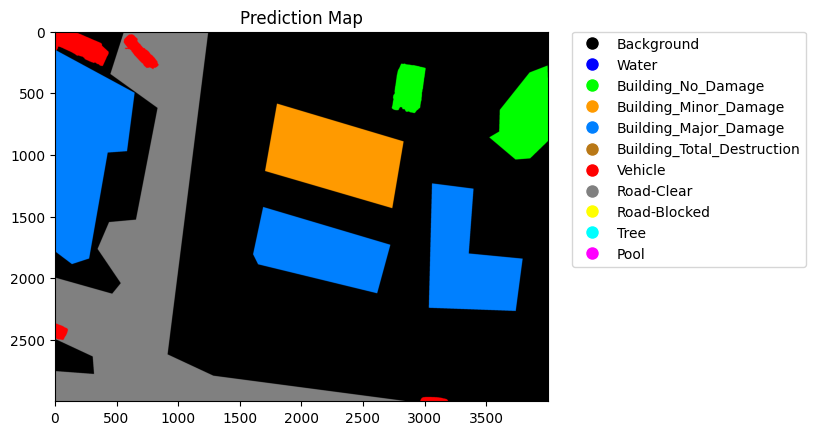

In [ ]:
# show label class label color map
img = cv.imread(train_label_path+'12850_lab.png')
display_classmap(img)

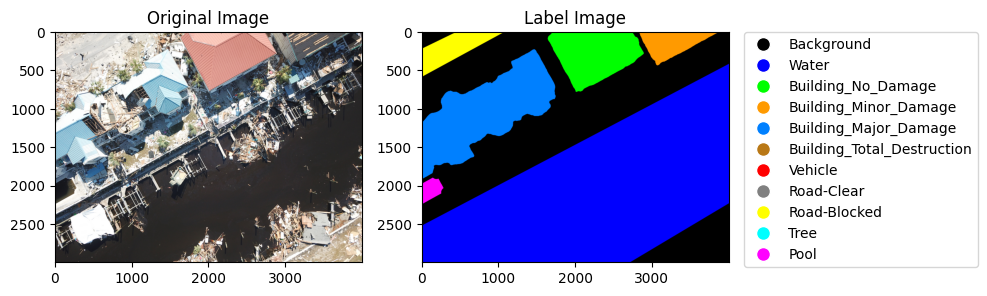

In [ ]:
# show color map next to original image
display_org_label(train_org_path, train_label_path, 1)

### Preprocessing & Dataset

In [ ]:
# RescueNet dataset class object
class RescueNetDataset(torch.utils.data.Dataset):
  def __init__(self, org_path, label_path, size=(800,500)): #
    self.org_path = org_path # set orginal image path
    self.label_path = label_path # set label image path
    self.size = size # set image resize

    # preprocess original image, turn into tensor, normailize according to deeplabV3 documentation
    self.org_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # get filenames for image. store for use in getitem func so that image can be used for model evaluation
    self.org_files = os.listdir(self.org_path)
    self.org_files.sort()

    self.label_files = os.listdir(self.label_path)
    self.label_files.sort()

  # get size of dataset
  def __len__(self):
    return len(self.org_files)

  def __getitem__(self,idx):
    # read in original image, update color format, 0 to 1 scaling, resize for ease of computation
    org = cv.imread(self.org_path+self.org_files[idx])
    if org.size != (3000, 4000, 3): # check if image is the expected size
      org = org[:3000, :4000,:]
    org = cv.cvtColor(org, cv.COLOR_BGR2RGB) # convert to RBG
    org = org.astype(np.float32) / 255.0 # normalize pixel values from 0 to 1

    # read in label image, update color format
    label = cv.imread(self.label_path+self.label_files[idx])
    label = cv.cvtColor(label, cv.COLOR_BGR2RGB)
    if label.size != (3000, 4000, 3):
      label = label[:3000, :4000,:] # if image is not expect size, crop image
      
    # transform numpy arrays to tensors and remove channel dimension of label images. not needed for loss/iou calculations
    org = self.org_transform(org)
    label = torch.from_numpy(label)
    channel = 1
    label = label[:,:,channel].unsqueeze(dim=0)

    return self.org_files[idx], org, label

### Create Model

In [ ]:
# create DeepLabV3 model object
class CustomDeepLabV3(torch.nn.Module):
    # intialize model classes number, input size, oupt size, and model head
    def __init__(self, num_classes=11, input_size=(500, 800), output_size=(3000,4000)):
        super(CustomDeepLabV3, self).__init__()
        self.base_model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        self.base_model.classifier = DeepLabHead(2048, num_classes)
        self.base_model.aux_classifier = DeepLabHead(1024, num_classes)
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, x):
        # interprolate input image to model input size
        input = F.interpolate(x, size=self.input_size, mode='bilinear', align_corners=False)
        # perform model inference
        x = self.base_model(input)
        # interprolate model output back up to label image size. for both heads
        output = F.interpolate(x['out'], size=self.output_size, mode='bilinear', align_corners=False)
        aux_output = F.interpolate(x['aux'], size=self.output_size, mode='bilinear', align_corners=False)
        return output, aux_output

In [ ]:
# initialize model 1 and model 1
DL3_model_1 = CustomDeepLabV3(num_classes=11, input_size=(800,500), output_size=(3000,4000))
DL3_model_2 = CustomDeepLabV3(num_classes=11, input_size=(800,500), output_size=(3000,4000))

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 232MB/s]


In [ ]:
# load in trained model
model1_weights_file = model_path + 'model_1_weigths.pth'
DL3_model_1.load_state_dict(torch.load(model1_weights_file))

model2_weights_file = model_path + 'model_2_weigths.pth'
DL3_model_2.load_state_dict(torch.load(model2_weights_file))

<All keys matched successfully>

## Training Loop

### Train Model 1

TRAINING Notes for Model 1
- trained model 1 for 3 epochs on all layers
- freezing pretrained layers and only train new head layers

In [ ]:
# # unfreeze weights
# for name, param in DL3_model.base_model.named_parameters():
#   if 'classifier' in name or 'aux_classifier' in name:
#     param.requires_grad = True

# freeze weights
for name, param in DL3_model_1.base_model.named_parameters():
  if 'classifier' not in name and 'aux_classifier' not in name:
    param.requires_grad = False

In [ ]:
# initalize objects for training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
DL3_model_1.to(device)
loss_fn_main = torch.nn.CrossEntropyLoss()
loss_fn_aux = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DL3_model_1.parameters(), lr=0.001)
aux_weight = 0.4

train_set = RescueNetDataset(train_org_path, train_label_path, size=(800,500))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=25, shuffle=True) 

In [ ]:
# Run training loop
num_epochs = 7
batch_loss = []
start_time = time.time()
for epoch in range(num_epochs):
    DL3_model_1.train()
    running_loss = 0.0
    for batch_idx, (file_idx, image, label) in enumerate(train_loader):

        image, label = image.to(device), label.to(device)
        label = label.squeeze(1).long()  # Remove the channel dimension
        main_output, aux_output = DL3_model_1(image)

        main_loss = loss_fn_main(main_output, label)
        aux_loss = loss_fn_aux(aux_output, label)
        total_loss = main_loss + aux_weight * aux_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        batch_loss.append(total_loss.item())

        # print training results every tenth epochs
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {total_loss.item():.4f} ")
            print('runtime: ', time.time()-start_time)
            print('----------')


        del image, label, main_output, aux_output, main_loss, aux_loss, total_loss

    torch.save(DL3_model_1.state_dict(), model_path+"model1_epoch_"+str(epoch+1)+".pth")
    np.save(training_data_path+'model1_batch_loss.npy', np.array(batch_loss))
print('Finished Training')


Epoch [1/7], Batch [1/144], Loss: 3.6723 
runtime:  80.19642424583435
----------
Epoch [1/7], Batch [11/144], Loss: 1.2221 
runtime:  868.2110078334808
----------
Epoch [1/7], Batch [21/144], Loss: 1.2560 
runtime:  1661.2304022312164
----------
Epoch [1/7], Batch [31/144], Loss: 1.0742 
runtime:  2460.611516237259
----------
Epoch [1/7], Batch [41/144], Loss: 0.7846 
runtime:  3253.155502796173
----------
Epoch [1/7], Batch [51/144], Loss: 1.0326 
runtime:  4052.5200729370117
----------
Epoch [1/7], Batch [61/144], Loss: 0.7860 
runtime:  4918.371403455734
----------
Epoch [1/7], Batch [71/144], Loss: 0.7321 
runtime:  5716.427065849304
----------
Epoch [1/7], Batch [81/144], Loss: 0.9265 
runtime:  6517.325582265854
----------
Epoch [1/7], Batch [91/144], Loss: 0.9118 
runtime:  7299.186763763428
----------
Epoch [1/7], Batch [101/144], Loss: 0.8162 
runtime:  8115.1507477760315
----------
Epoch [1/7], Batch [111/144], Loss: 0.8218 
runtime:  8925.707570075989
----------
Epoch [1/7],

### Train Model 2

TRAINING Notes for Model 2
- freezing pretrained layers and only train new head layers for 7 epochs

In [ ]:
# freeze weights
for name, param in DL3_model_2.base_model.named_parameters():
  if 'classifier' not in name and 'aux_classifier' not in name:
    param.requires_grad = False

# initalize objects for training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
DL3_model_2.to(device)
loss_fn_main = torch.nn.CrossEntropyLoss()
loss_fn_aux = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DL3_model_2.parameters(), lr=0.001)
aux_weight = 0.4

train_set = RescueNetDataset(train_org_path, train_label_path, size=(800,500))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=25, shuffle=True) 

In [ ]:
# Run training loop
num_epochs = 7
batch_loss = []
start_time = time.time()
for epoch in range(num_epochs):
    DL3_model_2.train()
    running_loss = 0.0
    for batch_idx, (file_idx, image, label) in enumerate(train_loader):

        image, label = image.to(device), label.to(device)
        label = label.squeeze(1).long()  # Remove the channel dimension
        main_output, aux_output = DL3_model_2(image)

        main_loss = loss_fn_main(main_output, label)
        aux_loss = loss_fn_aux(aux_output, label)
        total_loss = main_loss + aux_weight * aux_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        batch_loss.append(total_loss.item())

        # print training results every tenth epochs
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {total_loss.item():.4f} ")
            print('runtime: ', time.time()-start_time)
            print('----------')

        del image, label, main_output, aux_output, main_loss, aux_loss, total_loss

    torch.save(DL3_model_2.state_dict(), model_path+"model2_epoch_"+str(epoch+1)+".pth")
    np.save(training_data_path+'model2_batch_loss.npy', np.array(batch_loss))
print('Finished Training')


### Graph Training Loss

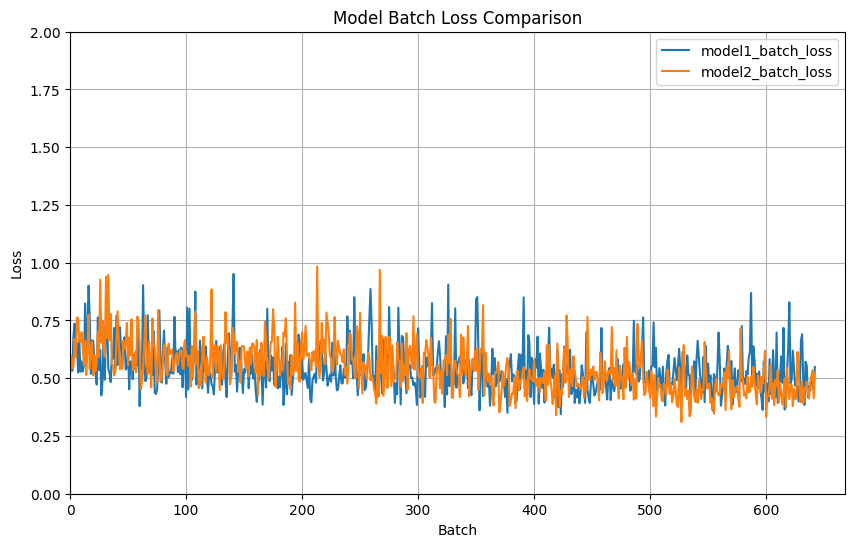

In [13]:
model1_batch_loss = np.load(training_data_path + '/model1_batch_loss.npy')
model2_batch_loss = np.load(training_data_path + '/model2_batch_loss.npy')

num_batches = len(model1_batch_loss)
# Truncate models to be the same number of data points
model2_batch_loss = model2_batch_loss[-num_batches:]


plt.figure(figsize=(10, 6))
plt.plot(model1_batch_loss, label='model1_batch_loss')
plt.plot(model2_batch_loss, label='model2_batch_loss')

# Add labels and title
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.xlim(0, num_batches+25)
plt.ylim(0, 2)
plt.title('Model Batch Loss Comparison')
plt.legend()
plt.grid(True)

plt.show()


## Validation Pipeline

In [ ]:
val_set = RescueNetDataset(val_org_path, val_label_path, size=(800,500))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=True)

model_1 iou: 0.597557008266449
eval time 81.21794724464417
11836.jpg


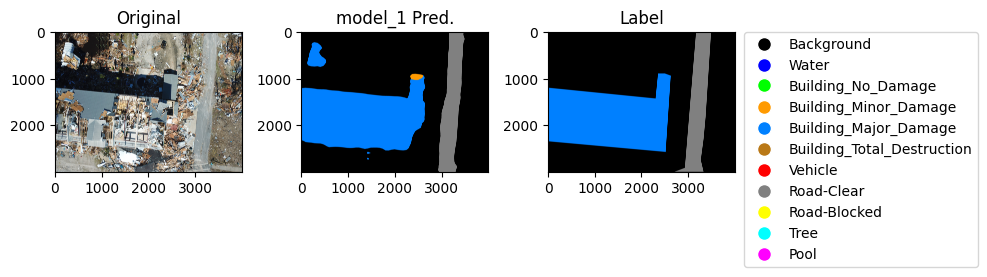

model_2 iou: 0.515002429485321
eval time 81.59989023208618
11836.jpg


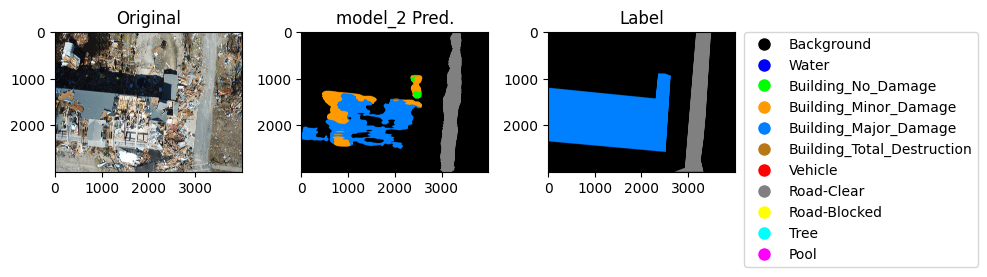

In [ ]:
SingleImage_evaluate({'model_1':DL3_model_1 ,'model_2':DL3_model_2}, val_loader, 'val')

#### IoU Evalution for Model 1

In [ ]:
# IoU Evaluation
iou_model1_val = MulticlassJaccardIndex(num_classes=11).to(device = "cuda" if torch.cuda.is_available() else "cpu") 
batch_val_1_iou = []
DL3_model_1.eval()
start = time.time()
for batch_idx, (file_idx, image, label)  in enumerate(val_loader):
  image, label = image.to(device), label.to(device)
  label = label.squeeze(1)  # Remove the channel dimension (assuming it's 1)
  main_output, _ = DL3_model_1(image)
  main_output = torch.argmax(main_output, dim=1)
  iou_model1_val.update(main_output, label)

  del image, label, main_output
  if batch_idx % 10 == 0:
    iou = iou_model1_val.compute()
    print(f"Batch [{batch_idx+1}/{len(val_loader)}], iou: {iou}")
    print('runtime: ', time.time()-start)
    batch_val_1_iou.append(iou)
    np.save(training_data_path+'iou_model_1.npy', np.array(batch_val_1_iou))

print("Validation Done")
print(f"Validation IoU: {iou_model1_val.compute()}")

Batch [1/45], iou: 0.44402432441711426
runtime:  96.68611812591553
Batch [11/45], iou: 0.5141282081604004
runtime:  948.4512519836426
Batch [21/45], iou: 0.5013821721076965
runtime:  1801.5281472206116
Batch [31/45], iou: 0.500204861164093
runtime:  2645.15021276474
Batch [41/45], iou: 0.5071520209312439
runtime:  3496.1197855472565
Validation Done
Validation IoU: 0.505584180355072


#### IoU Evaluation for Model 2

In [ ]:
# IoU Evaluation look
iou_model2_val = MulticlassJaccardIndex(num_classes=11).to(device = "cuda" if torch.cuda.is_available() else "cpu")
batch_val_iou = []
DL3_model_2.eval()
start = time.time()
for batch_idx, (file_idx, image, label)  in enumerate(val_loader):
  image, label = image.to(device), label.to(device)
  label = label.squeeze(1)  # Remove the channel dimension (assuming it's 1)
  main_output, _ = DL3_model_2(image)
  main_output = torch.argmax(main_output, dim=1)
  iou_model2_val.update(main_output, label)

  del image, label, main_output
  if batch_idx % 10 == 0:
    iou = iou_model2_val.compute()
    print(f"Batch [{batch_idx+1}/{len(val_loader)}], iou: {iou}")
    print('runtime: ', time.time()-start)
    batch_val_iou.append(iou)
    np.save(training_data_path+'iou_model_2.npy', np.array(batch_val_iou))

print("Validation Done")
print(f"Validation IoU: {iou_model2_val.compute()}")

Batch [1/45], iou: 0.3823468089103699
runtime:  117.88795614242554
Batch [11/45], iou: 0.47670817375183105
runtime:  1020.448310136795
Batch [21/45], iou: 0.4857557415962219
runtime:  1917.3910009860992
Batch [31/45], iou: 0.47306206822395325
runtime:  2812.5000228881836
Batch [41/45], iou: 0.47711190581321716
runtime:  3707.5329575538635
Validation Done
Validation IoU: 0.4757460653781891


## Reference

In [ ]:
# https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_deeplabv3_resnet101.ipynb
